In [10]:
import os

import torch
# import torchvision
from torchvision.transforms import v2

# from torch import nn
# from torchsummary import summary

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm

%load_ext autoreload

from data_loaders import *
%autoreload 2
from training_utils import *
%autoreload 2
from cnn_model import *
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# preds = torch.rand(20)
# target = torch.randint(2, (20,))
# metric = BinaryPrecisionRecallCurve()
# metric.update(torch.tensor([0.1, 0.1, 0.1, 0.3]), torch.tensor([0, 1, 0, 1]))
# fig_, ax_ = metric.plot(score=True, ax)
# plt.show()
# plt.close()

In [13]:
# Creating the datasets

transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Normalize(mean=[0], std=[67]),
    v2.ToDtype(torch.float, scale=True),
    # v2.ColorJitter(0.5, None, None, None),
    # v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.5))
])


# torchvision.transforms.ToTensor() 


test_prop = 0.0
val_prop = 0.3


labeled_data = CloudDetectionTrain(
    transform=transform
)
dataset_size = len(labeled_data)
dataset_indices = np.arange(dataset_size)

np.random.shuffle(dataset_indices)

# Test / Train split
test_split_index = int(np.floor(test_prop * dataset_size))
trainset_indices, test_idx = dataset_indices[test_split_index:], dataset_indices[:test_split_index]

# Train / Val split
trainset_size = len(trainset_indices)
val_split_index = int(np.floor(val_prop * trainset_size))
train_idx, val_idx = trainset_indices[val_split_index:], trainset_indices[:val_split_index]



batch_size = 64


# NUM_TRAIN = int(len(labeled_data) * proportion_train)
# NUM_TRAIN = NUM_TRAIN - NUM_TRAIN % batch_size


# val_split_index = int(np.floor(proportion_val * dataset_size))
# train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_loader = torch.utils.data.DataLoader(
  dataset=labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_idx)
)

train_loader = torch.utils.data.DataLoader(
  dataset=labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_idx)
)

val_loader = torch.utils.data.DataLoader(
  dataset=labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(val_idx)
)



# inference_data = CloudDetectionInference(
#     batch_id = 10,
#     transform = transform
# )
# inference_loader = torch.utils.data.DataLoader(
#   dataset=inference_data,
#   batch_size=batch_size
# )




img_type = 'raw-derivative.-60'
# img_type = 'raw-original'
# img_type = 'raw-fft'

In [15]:
labeled_data.dsl_df
feature_uid = labeled_data.dsl_df.loc[:, 'feature_uid'].iloc[0]
# pano_feature_fpath = labeled_data.dataset_manager.get_pano_feature_fpath(feature_uid, 'fft')
# pano_feature_fpath
labeled_data[0][0]
num_clear = len(labeled_data.dsl_df.loc[labeled_data.dsl_df.label == 'clear_night_sky'])
num_cloudy = len(labeled_data.dsl_df.loc[labeled_data.dsl_df.label == 'not_clear_cloudy'])
print(f'Percent cloudy = {100 *num_cloudy / len(labeled_data):.3f}% ({num_cloudy} / {len(labeled_data)})')

Percent cloudy = 53.054% (7356 / 13865)


In [16]:
rn = np.random.choice(len(labeled_data), size=30, replace=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


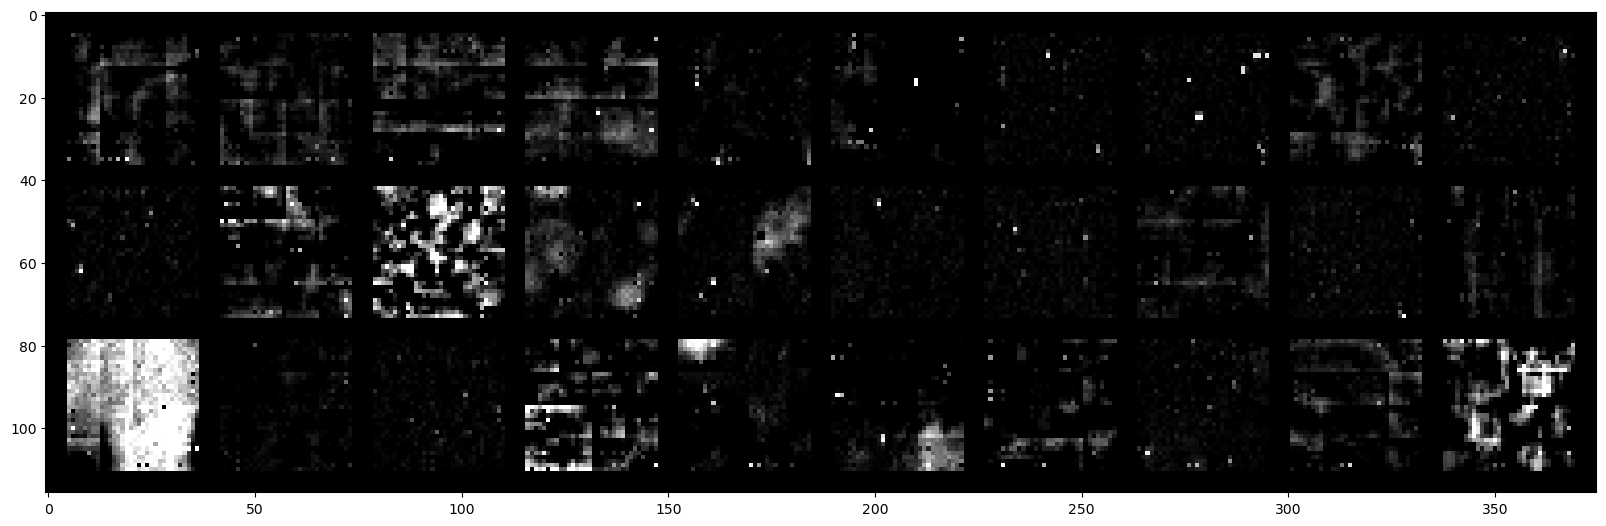

In [17]:
labeled_data.dataset_manager.main_dfs['feature']['batch_id'].unique()
images = [labeled_data[i][0][img_type] for i in rn]
plt.figure(figsize=(20,10))
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)))

In [18]:
torch.min(images[0])

tensor(-0.7065)

In [20]:
# Training config

learning_rate = 0.001
# momentum=0.9

model = CloudDetection()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=10, gamma=0.9, do_summary=False,
    img_type=img_type
);



Epoch 1


  0%|          | 0/152 [00:00<?, ?batches/s]

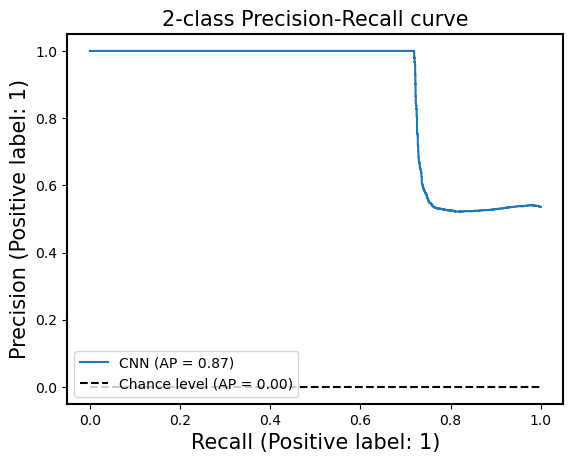

       Val: 	loss = 0.1258,  acc = 4020/4159 (96.66%) 
      Train: 	loss = 0.1407,  acc = 9269/9706 (95.50%)


Epoch 2


  0%|          | 0/152 [00:00<?, ?batches/s]

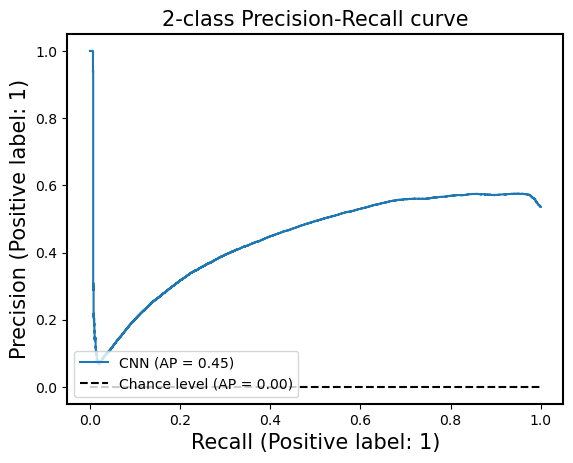

       Val: 	loss = 0.1464,  acc = 3948/4159 (94.93%) 
      Train: 	loss = 0.1617,  acc = 9099/9706 (93.75%)


Epoch 3


  0%|          | 0/152 [00:00<?, ?batches/s]

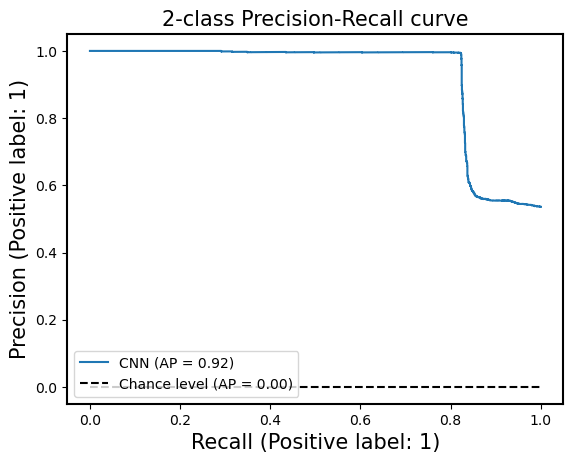

       Val: 	loss = 0.1269,  acc = 4014/4159 (96.51%) 
      Train: 	loss = 0.1400,  acc = 9268/9706 (95.49%)


Epoch 4


  0%|          | 0/152 [00:00<?, ?batches/s]

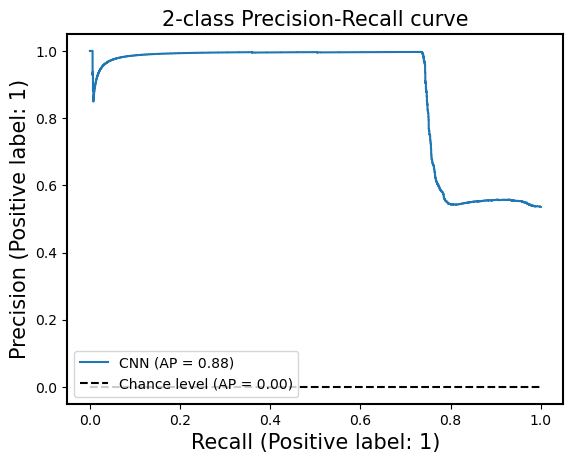

       Val: 	loss = 0.1549,  acc = 4011/4159 (96.44%) 
      Train: 	loss = 0.1650,  acc = 9295/9706 (95.77%)


Epoch 5


  0%|          | 0/152 [00:00<?, ?batches/s]

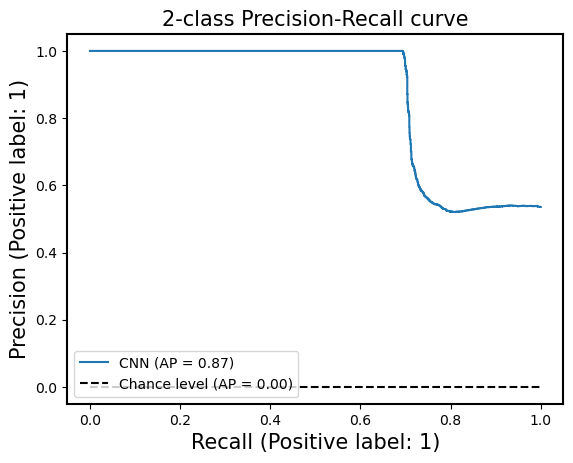

       Val: 	loss = 0.1155,  acc = 4025/4159 (96.78%) 
      Train: 	loss = 0.1279,  acc = 9327/9706 (96.10%)


Epoch 6


  0%|          | 0/152 [00:00<?, ?batches/s]

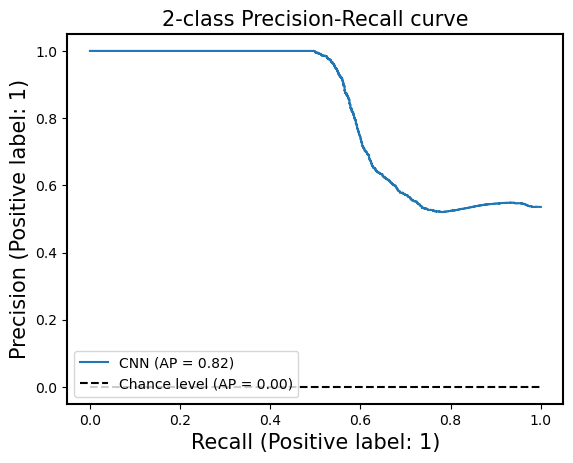

       Val: 	loss = 0.1352,  acc = 4033/4159 (96.97%) 
      Train: 	loss = 0.1478,  acc = 9315/9706 (95.97%)


Epoch 7


  0%|          | 0/152 [00:00<?, ?batches/s]

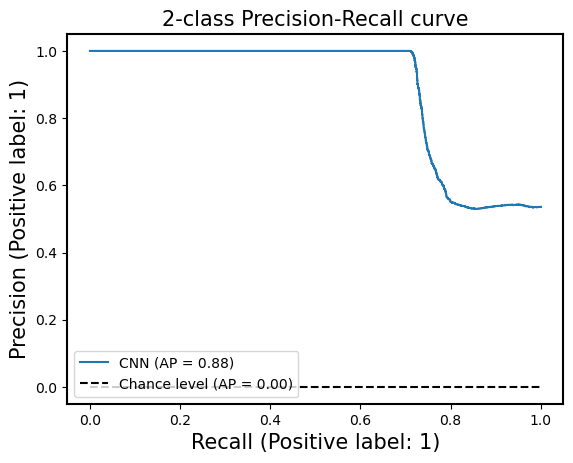

       Val: 	loss = 0.1308,  acc = 4020/4159 (96.66%) 
      Train: 	loss = 0.1429,  acc = 9305/9706 (95.87%)


Epoch 8


  0%|          | 0/152 [00:00<?, ?batches/s]

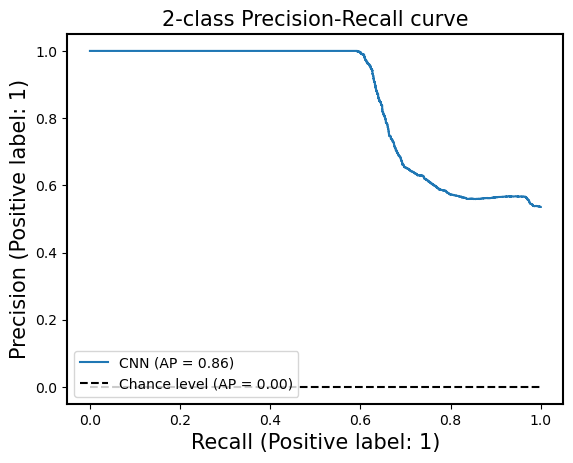

       Val: 	loss = 0.1383,  acc = 4012/4159 (96.47%) 
      Train: 	loss = 0.1501,  acc = 9280/9706 (95.61%)


Epoch 9


  0%|          | 0/152 [00:00<?, ?batches/s]

In [ ]:
trainer.train()

In [ ]:
trainer.make_training_plots(do_save=False);

In [77]:
del model

In [ ]:
fig, ax = trainer.bprc.plot(score=True)

In [79]:
# images = [labeled_data[i][0][img_type] for i in np.random.choice(len(labeled_data), size=5000, replace=False)]
images = [labeled_data[i][0][img_type] for i in np.random.choice(len(labeled_data), size=2000, replace=False)]

# plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)))
print(np.mean(images), np.std(images))

0.1069171 67.71992


In [77]:
print(np.mean(images), np.std(images))

-0.58229965 67.26903


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


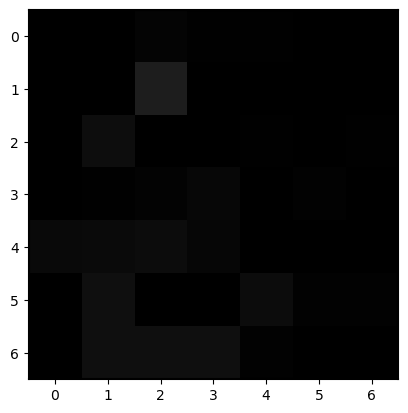

In [18]:
images = [labeled_data[i][0][img_type] for i in np.random.choice(len(labeled_data), size=1, replace=False)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=10, padding=5).numpy().transpose((1, 2, 0)), vmin=-0.5, vmax=0.5, cmap='icefire')

In [ ]:
# ---- Plotting ----
plt.figure(figsize=(15, 10))

def plot_loss(log, save=True):
    train_loss = log['train']['loss']
    val_loss = log['val']['loss']
    
    plt.plot(train_loss, label="training loss")
    plt.plot(val_loss, label="validation loss")
    
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    
    plt.title("Cloud-Detection Training and Validation Loss vs Epoch")
    if save:
        plt.savefig("Loss")
        plt.close()

def plot_accuracy(log, save=True):
    train_acc = log['train']['acc']
    val_acc = log['val']['acc']
    
    plt.plot(train_acc, label="training accuracy")
    plt.plot(val_acc, label="validation accuracy")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    
    plt.title("Cloud-Detection Training and Validation Accuracy vs Epoch")
    if save:
        plt.savefig(f"Accuracy")
        plt.close()
        
def plot_cloudy_mistakes(log, save=True):
    train_acc = log['train']['cloudy_wrong']
    val_acc = log['val']['cloudy_wrong']
    
    plt.plot(train_acc, label="training cloudy_wrong")
    plt.plot(val_acc, label="validation cloudy_wrong")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    
    plt.title("Cloud-Detection Training and percent cloudy misclassifications vs Epoch")
    if save:
        plt.savefig(f"cloudy_wrong")
        plt.close()

def plot_clear_mistakes(log, save=True):
    train_acc = log['train']['clear_wrong']
    val_acc = log['val']['clear_wrong']
    
    plt.plot(train_acc, label="training clear_wrong")
    plt.plot(val_acc, label="validation clear_wrong")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    
    plt.title("Cloud-Detection Training and percent clear misclassifications vs Epoch")
    if save:
        plt.savefig(f"clear_wrong")
        plt.close()

In [ ]:
# Utils

def get_device(verbose=False):
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    else:
        "cpu"
    if verbose: print(f"Using device {device}")
    return device


def make_training_log():
    training_log = {
        'train': {
            'loss': [],
            'acc': [],
            'cloudy_wrong': [],
            'clear_wrong': []
        },
        'val': {
            'loss': [],
            'acc': [],
            'cloudy_wrong': [],
            'clear_wrong': []
        }
    }
    
    return training_log

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
    if isinstance(m, nn.LazyLinear):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.xavier_uniform_(m, gain=nn.init.calculate_gain('relu'))
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))

device = get_device()

In [ ]:
cloudy_wrong_data = []
clear_wrong_data = []
def record_acc_and_loss(model, loss_fn, data_loader, log, data_set):
    ncorrect = 0
    nsamples = 0
    loss_total = 0
    ncloudy_wrong = 0
    nclear_wrong = 0
    
    model.eval()
    with torch.no_grad():
        for img_data, y in data_loader:
            x = img_data[img_type]
            x = x.to(device=device, dtype=torch.float) 
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            
            loss = loss_fn(scores, y)
            loss_total += loss.item()
            
            predictions = torch.argmax(scores, dim=1)
            ncorrect += (predictions == y).sum()
            
            # if ((predictions == 1) & (predictions != y)).cpu().any():
            #     for im, pred in zip(x, predictions):
            #         cloudy_wrong_data.append(im.cpu())
            # elif ((predictions == 0) & (predictions != y)).cpu().any():
            #     for i in range(len(predictions)):
            #         if predictions[i] == 0 and predictions[i] != y[i]:
            #             clear_wrong_data.append(x[i].cpu())
            for i in range(len(predictions)):
                    if predictions[i] == 1 and predictions[i] != y[i]:
                        cloudy_wrong_data.append(x[i].cpu())
                    elif predictions[i] == 0 and predictions[i] != y[i]:
                        clear_wrong_data.append(x[i].cpu())

            ncloudy_wrong += ((predictions == 1) & (predictions != y)).cpu().sum()
            nclear_wrong += ((predictions == 0) & (predictions != y)).cpu().sum()
            nsamples += predictions.size(0)
            
        avg_loss = loss_total / len(data_loader)
        acc = float(ncorrect) / nsamples
        
        log[data_set]['loss'].append(avg_loss)
        log[data_set]['acc'].append(acc)
        log[data_set]['cloudy_wrong'].append(ncloudy_wrong / max(nsamples - float(ncorrect), 1))
        log[data_set]['clear_wrong'].append(nclear_wrong / max(nsamples - float(ncorrect), 1))

        
        report = "{0}: \tloss = {1:.4f},  acc = {2}/{3} ({4:.2f}%)".format(data_set.capitalize().rjust(10), avg_loss, ncorrect, nsamples, acc * 100)
        return report


def train(model, optimizer, loss_fn, epochs=1, gamma=0.9):
    """
    Train the given model and report accuracy and loss during training.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: dictionary of train and validation loss and accuracy for each epoch.
    """
    # Move model to device
    model = model.to(device=device)
    
    # Init LR schedulers
    scheduler_exp = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    scheduler_plat = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    training_log = make_training_log()
    for e in range(1, epochs + 1):
        print(f"\n\nEpoch {e}")
        for img_data, y in tqdm.tqdm(train_loader, unit="batches"):
            model.train()
            x = img_data[img_type]
            x = x.to(device=device, dtype=torch.float) 
            y = y.to(device=device, dtype=torch.long)
            
            # Forward pass: compute class scores
            scores = model(x)
            loss = loss_fn(scores, y)
            
            # Remove the gradients from the previous step
            optimizer.zero_grad() 
            
            # Backward pass: update weights
            loss.backward()
            optimizer.step()
        
        # Update log of train and validation accuracy and loss. Print progress.
        train_report = record_acc_and_loss(model, loss_fn, train_loader, training_log, 'train')
        valid_report = record_acc_and_loss(model, loss_fn, val_loader, training_log, 'val')
        print(valid_report, '\n', train_report)
        
        # Save model parameters with best validation accuracy
        val_accs = training_log['val']['acc']
        if val_accs[-1] == max(val_accs):
            torch.save(model.state_dict(), "../model_training/best_cloud_detection_model.pth")
         
        # Update optimizer
        scheduler_exp.step()
        scheduler_plat.step(training_log['val']['loss'][-1])
    print('Done training')
    return training_log

In [ ]:
class CloudDetection(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 126, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(126),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(126, 126, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(126),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(126, 126, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(126),
            nn.Dropout2d(p=0.1),
            
            nn.MaxPool2d(kernel_size=2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(126, 200, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(200),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(200, 200, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(200),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(200, 200, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(200),
            nn.Dropout2d(p=0.1),
            
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(200, 256, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # nn.Dropout2d(p=0.1),

            nn.Conv2d(256, 256, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # nn.Dropout2d(p=0.1),
            
            nn.Conv2d(256, 256, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            # nn.Dropout2d(p=0.1),

            nn.MaxPool2d(kernel_size=2),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout2d(p=0.1),
            
            nn.Conv2d(512, 512, 3, stride=1, padding='same', groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout2d(p=0.1),

            nn.Conv2d(512, 512, 3, stride=1, groups=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout2d(p=0.1),
            
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()

        self.linear_stack = nn.Sequential(
            nn.LazyLinear(2000),
            nn.ReLU(),
            nn.BatchNorm1d(2000),
            nn.Dropout1d(p=0.2),
            
            nn.LazyLinear(1000),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Dropout1d(p=0.2),

            nn.LazyLinear(512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            # nn.Dropout1d(p=0.1),
            
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.LazyLinear(4),
        )
        
        # self.cnns = torch.nn.ModuleList([torch.nn.Sequential(self.conv1(), self.conv2(), self.conv3(), self.flatten()) for _ in range(3)])
        
    def forward_convolve(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flatten(out)
    
    def forward_fc(self, xs: list[torch.Tensor]):
        outs = []
        for x in xs:
            pass
        # out = self.conv1(x)
        # out = self.conv2(out)
        # out = self.conv3(out)
        # out = self.conv4(out)
        # out = self.flatten(out)
        #print(out.shape)
        # self.foward_convolve(
        
        out = self.linear_stack(out)
        return out
            
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flatten(out)
        # print(out.shape)
        
        out = self.linear_stack(out)
        return out
    
    

def get_model_summary(dummy_model, labeled_data, input_shape=(3, 32, 32)):
    """Get the current model configuration."""
    dummy_loader = torch.utils.data.DataLoader(
      dataset=labeled_data,
      batch_size=1,
      sampler=torch.utils.data.SubsetRandomSampler(range(3))
    )
    dummy_model.to(device=get_device())
    dummy_model.eval()
    with torch.no_grad():
        img_data, y = next(iter(dummy_loader))
        x = img_data[img_type]
        x = x.to(device=device, dtype=torch.float)
        y = y.to(device=device, dtype=torch.long)
        scores = dummy_model(x)
    try:
        s = summary(dummy_model)
        with open('model_summary.txt', 'w') as f:
            f.write(str(s))
    except ValueError as verr:
        print(verr)
    finally:
        dummy_model.cpu()
        del dummy_loader

get_model_summary(CloudDetection(), labeled_data)

In [ ]:
# Training config
learning_rate = 0.001
# momentum=0.9

model = CloudDetection()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

training_log = train(model, optimizer, loss_fn, epochs=1, gamma=0.9)


plot_accuracy(training_log)
plot_loss(training_log)
plot_cloudy_mistakes(training_log)
plot_clear_mistakes(training_log)
plt.close()

In [ ]:
# Create the test dataset
# testing_data = 
# CloudDetectionTest(
#     transform=transform, # NOTE: Make sure transform is the same as the one used in the training dataset.
# )
plt.figure(figsize=(12,6))
processed = [img / 255 for img in clear_wrong_data]
# plt.imshow(torchvision.utils.make_grid(torch.stack(processed[:len(processed)]), nrow=10, padding=5).numpy().transpose((1, 2, 0)))

In [ ]:
# Generate predictions.csv file.
import pandas as pd

predictions = predictions.cpu()

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})

